In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def extract_data(line):
    line = line.replace('B-', 'B -').replace('A-', 'A -')
    values = line.split()
    fields = ['std pressure level', 'minor level type', 'elapsed_time',
              'pressure', 'pressure flag', 'height', 'ground height', 'temperature',
              'temp flag', 'humidity', 'depoint', 'wind dir', 'wind speed']
    datum = [(field, value) for field, value in zip(fields, values)]
    for i, (field, value) in enumerate(datum):
        if field in {'elapsed_time', 'height', 'pressure'}:
            if value[-1] == 'B':
                value = value[:-1]
            if value in {-9999, '-9999'} or value[-1] == 'A' \
               or (field == 'height' and float(value) < 0):
                datum[i] = (field, None)
            else:
                datum[i] = (field, float(value))
    return {k: v for k, v in datum if k not in ['minor level type', 'temperature',
                                                'temp flag', 'humidity', 'depoint',
                                                'wind dir', 'wind speed', 'elapsed_time',
                                                'ground height', 'pressure flag', 'std pressure level']}

def get_data(lines):
    data = [extract_data(line) for line in lines] 
    return data

def get_info(header):
    info = header.split()
    info_fields = [None, 'year', None , None, None,
                   None, None, None, None, None, None]
    info = dict(zip(info_fields, info))
    del info[None]
    info['year'] = int(info['year'])
    return info

def get_pressures(filename):
    with open(filename, 'r') as f:
        lines = [line.replace('\n', '') for line in f.readlines()]

    headers = [i for i, line in enumerate(lines) if line[0] == '#']
    n_launches = len(headers)

    dataset = []
    for h1, h2 in zip(headers[:-1], headers[1:]):
        data = get_data(lines[h1 + 1:h2])
        info = get_info(lines[h1])
        for d in data:
            d.update(info)
        dataset += data
    return dataset, n_launches

In [3]:
import os
dir = 'noaa-igra/'

data = []
meta = {'stations': 0, 'n_launches': 0}
n_launches = 0
for file in os.listdir(dir):
    if file in {'.DS_Store', 'data'}:
        continue
    datum, n_launches_station = get_pressures(dir + file)
    data += datum
    meta['n_launches'] += n_launches_station
    meta['stations'] += 1
    print(len(data), file)

494061 ACM00078861-data.txt
703899 AGM00060566-data.txt
707036 AGM00060686-data.txt
1327564 AMM00037789-data.txt
1340362 ARM00087827-data.txt
1340854 ASM00094266-data.txt
3602451 ASM00094294-data.txt
3711853 ASM00094305-data.txt
3970617 ASM00094335-data.txt
5346201 ASM00094430-data.txt
5367170 ASM00094568-data.txt
6336285 BOM00033008-data.txt
6979295 BRM00082022-data.txt
7682014 BRM00082281-data.txt
8547064 BRM00083827-data.txt
9222861 CAM00071802-data.txt
12006745 CAM00071925-data.txt
12630914 CHM00051777-data.txt
13068866 CHM00052983-data.txt
13078738 CHM00056374-data.txt
13100525 CHM00059838-data.txt
13113260 CTM00064610-data.txt
13245120 CYM00017601-data.txt
13247709 EGXUAE04942-data.txt
13257530 EGXUAE04953-data.txt
13265653 EGXUAE04974-data.txt
16716686 EIM00003953-data.txt
16726520 FIXUAC00035-data.txt
16729711 FIXUAE05526-data.txt
18580144 FKM00088889-data.txt
18621222 FKM00088890-data.txt
19696974 FRM00007180-data.txt
21551633 FRM00007645-data.txt
21607790 GHM00065418-data.txt

In [4]:
meta

{'n_launches': 2178040, 'stations': 120}

In [4]:
# 50e6 shows positive results
df = pd.DataFrame(data)
print("Memory GB =", df.values.nbytes / (1024**3))
print("Number of measurements =", len(df))
df.head()

Memory GB = 1.5692298263311386
Number of measurements = 70206154


,height,pressure,year
0,820.0,10.0,1947
1,830.0,156.0,1947
2,930.0,1559.0,1947
3,130.0,3187.0,1947
4,380.0,5894.0,1947


In [124]:
print(n_launches)

0


In [125]:
import numpy as np
plt.style.use('seaborn')
show = df.pivot_table(values='pressure', index='height',
                      aggfunc=np.median)
show.head()

height
0.0    13111.0
1.0    11980.0
2.0    11579.0
3.0    15840.0
4.0    27306.0
Name: pressure, dtype: float64

In [126]:
from altair import Chart, X, Bin

alt = pd.DataFrame({'height': show.index, 'pressure': show.values})
alt.shape

(1001, 2)

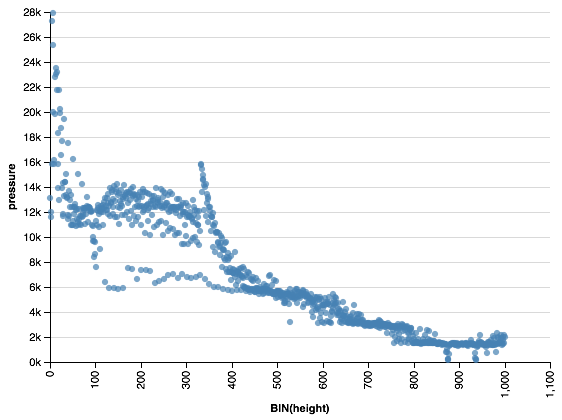

In [127]:
Chart(alt).mark_circle().encode(
    x=X('height', bin=Bin(step=1)), y='pressure')

* PRESS is the reported pressure (Pa or mb * 100, e.g.,  100000 = 1000 hPa or 1000 mb). -9999 = missing.
* GPH 		is the reported geopotential height (meters above sea level). This value is often not available at variable-pressure levels. The following special values are used:

In [128]:
prob_pressure = alt['pressure'] / alt['pressure'].sum()
mean_height = (prob_pressure * alt['height']).sum()

heights = np.arange(1, 1000)
pressure = np.exp(-heights / mean_height) * 1 / mean_height 

alt['pressure_normalized'] = alt['pressure'] / alt['pressure'].sum()

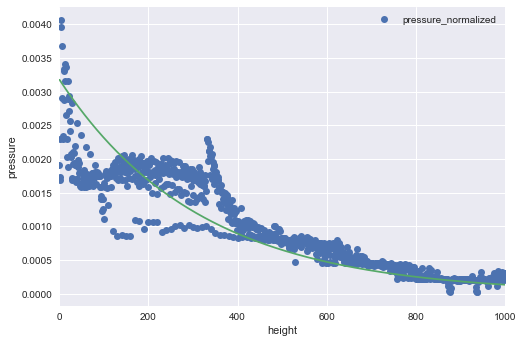

In [129]:
_ = alt.plot(x='height', y='pressure_normalized', kind='line', style='o')
_ = plt.ylabel('pressure')
plt.plot(heights, pressure)
plt.show()